# Welcome!
This notebook demonstrates how to develop a conversational system that uses a deep knowledge base about hotels, combining structured instance-level data and an ontological model. The knowledge graph (KG) and ontology enable reasoning to enhance dialogue response generation. The task involves integrating a GraphRAG-like approach to query the knowledge base and generate accurate, context-aware responses.

Specifically, the notebook has the following steps:

1. **Setup**: Loading the knowledge graph, dialogues, and required libraries (e.g., OWLAPY).
2. **Analyzing the knowledge graph**: Exploring its structure and entities using OWLAPY queries.
3. **Extending the ontology**: Adding TBox information for expressive reasoning.
4. **Creating dialogues**: Create dialogues based on the examples. Write 5 simple dialogues and 5 more detailed ones to showcase different types of interactions.
5. **Combining ontology and KG data**: Deploying an OWL reasoner to perform class-expression queries.
6. **Query generation with LLMs**: Using an LLM (e.g., Llama3.2) to generate or assist in creating queries against the KG.
7. **Generating responses**: Summarizing retrieved data into dialogue responses using a KG-augmented RAG approach.
8. **Evaluation**: Assessing the system's performance using metrics like intersection-over-union scores.

## Assignment
The goal of this assignment is to develop a logic-enhanced conversational system that retrieves and reasons over domain knowledge to assist in dialogue response generation. You will focus on both the technical aspects of KG+ontology reasoning and the integration with LLMs for robust responses.

### Assignment Steps
1. **Analyze the provided knowledge graph and dialogues**:
   - Explore the KG's entities, properties, and relevance to the dialogues.
   - Identify opportunities where ontology reasoning enhances dialogue responses.
2. **Extend the ontology**:
   - Add expressive TBox information to support meaningful inferences.
3. **Deploy the reasoning environment**:
   - Use OWLAPY to combine the KG (as ABox) with the ontology for reasoning-based queries.
4. **Generate class-expression queries**:
   - Use instruction-based, few-shot prompting with Llama3.2 to produce or assist in creating the queries.
5. **Summarize results into dialogue responses**:
   - Apply KG-augmented RAG to generate user-facing answers based on reasoning results.
6. **Evaluate the system**:
   - Use appropriate metrics, including intersection-over-union scores for set-based answers.

## Report
Write a **5-page report** in LNCS format that includes:

1. **Introduction**: Background on conversational systems with LLMs and the role of reasoning over domain knowledge.
2. **Methodology**: A detailed description of your approach, including diagrams and examples.
3. **Results**: Evaluation findings from the implemented steps.
4. **Discussion**: Strengths and weaknesses of your approach, lessons learned, and potential improvements.

Make sure to use the following template: [Springer Lecture Notes in Computer Science](https://www.overleaf.com/latex/templates/springer-lecture-notes-in-computer-science/kzwwpvhwnvfj)


## Grading
Your work will be evaluated based on:

1. **Code Implementation (30%)**: Quality and functionality of the logic-enhanced conversational system.
2. **Report (70%)**: Depth of analysis and clarity in presenting methods, results, and lessons learned.

## Kaggle Environment Notes
To ensure smooth execution:
- Load the required data into `/kaggle/input/`.
- Use `/kaggle/working/` for saving temporary files.
- Turn on GPUs and internet connectivity when necessary, and follow best practices for resource management.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python

# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input director

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/rdfontology/data.rdf


# Install packages

In [2]:
!pip install jpype1==1.5.2
!pip install owlapy==1.5.1 
!pip install ollama

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 493.5/493.5 kB 12.6 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.3/27.3 MB 65.6 MB/s eta 0:00:0000:0100:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.2/17.2 MB 69.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 587.2/587.2 kB 33.5 MB/s eta 0:00:00
  Created wheel for owlready2: filename=owlready2-0.49-py3-none-any.whl size=23742426 sha256=44275374e9b6278271a2a8e0b77453d2a14a26530b199c0dd960c56f6ace3fbb
  Stored in directory: /root/.cache/pip/wheels/43/fe/dc/a0de3c289cfd5923ece6524469d328950e14fa0c90b1088ffa
Successfully built owlready2


# Import libraries


In [3]:
from owlapy import manchester_to_owl_expression, dl_to_owl_expression
from owlapy.iri import IRI
from owlapy.owl_ontology import Ontology
from owlapy.owl_reasoner import SyncReasoner, StructuralReasoner


import matplotlib.pyplot as plt
from collections import Counter

# 1. Analyze the provided knowledge graph (data.ttl).

## Loading ontology

In [4]:
from pathlib import Path
from owlapy.iri import IRI
from owlapy.owl_ontology import Ontology

path = Path("/kaggle/input/rdfontology/data.rdf")

# hard sanity checks
print("Exists:", path.exists())
print("Size (bytes):", path.stat().st_size)

onto = Ontology(IRI.create(path.as_uri()), load=True)

print("Ontology loaded successfully.")


Exists: True
Size (bytes): 1071481
Ontology loaded successfully.


In [5]:
print("Classes:", len(list(onto.classes_in_signature())))
print("Object properties:", len(list(onto.object_properties_in_signature())))
print("Data properties:", len(list(onto.data_properties_in_signature())))
print("Individuals:", len(list(onto.individuals_in_signature())))


Classes: 34
Object properties: 9
Data properties: 0
Individuals: 1746


## Helpers for analysis ontology

In [6]:
def get_label(entity, ontology) -> str:
    """
    Get the rdfs:label for an entity from the ontology.
    Falls back to extracting local name from IRI if no label exists.
    """
    # Get the IRI first
    if hasattr(entity, "get_iri") and callable(entity.get_iri):
        iri_obj = entity.get_iri()
    elif hasattr(entity, "iri"):
        iri_obj = entity.iri
    else:
        return str(entity)
    
    # Try to get rdfs:label from the underlying owlready2 ontology
    try:
        # Access the underlying owlready2 world
        owlready_onto = ontology._onto
        
        # Get IRI as string
        if hasattr(iri_obj, "as_str") and callable(iri_obj.as_str):
            iri_str = iri_obj.as_str()
        else:
            iri_str = str(iri_obj)
        
        # Search for entity in owlready2 ontology and get its label
        with owlready_onto:
            entity_obj = owlready_onto.world.search_one(iri=iri_str)
            if entity_obj and hasattr(entity_obj, 'label') and entity_obj.label:
                # Return first label (they're usually lists)
                labels = entity_obj.label
                if labels and len(labels) > 0:
                    return str(labels[0])
    except:
        pass
    
    # Fallback: extract local name from IRI
    if hasattr(iri_obj, "as_str") and callable(iri_obj.as_str):
        iri_str = iri_obj.as_str()
    else:
        iri_str = str(iri_obj)

    return iri_str.rstrip("/").rsplit("/", 1)[-1]

## Plotting and analysis


Ontology summary

Classes:           34
Object properties: 9
Data properties:   0
Individuals:       1746


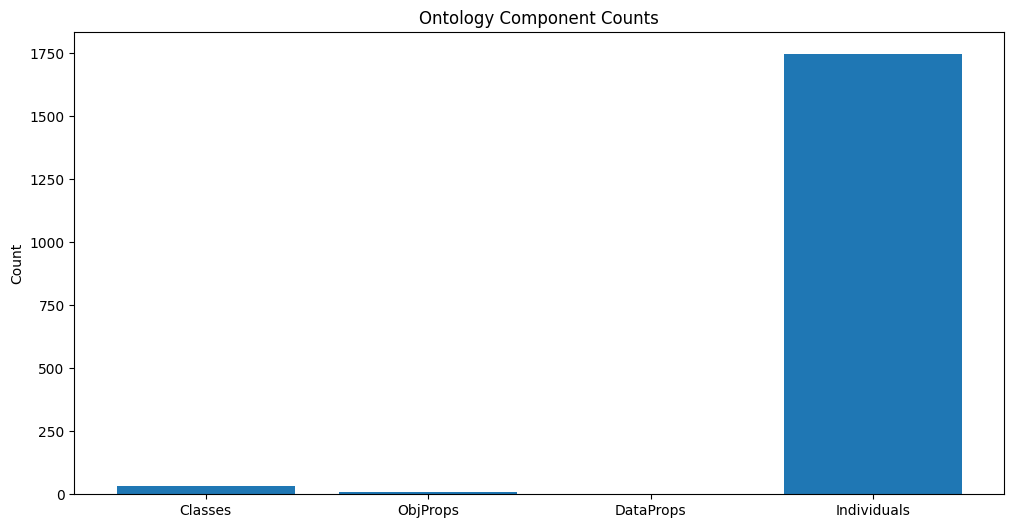



Individual type distribution (direct/asserted)

Unique classes with >=1 typed instance: 28

Top 15 classes by instance count:
             Class  Count
        Restaurant    506
             Hotel    344
      Camping Site    342
            Hostel    314
     Neighbourhood    267
            Museum     55
              City     34
      Trainstation     22
             River     12
       Nationality     10
          Facility      8
Tourist Attraction      8
           Country      5
   Restaurant Type      5
       User Rating      5


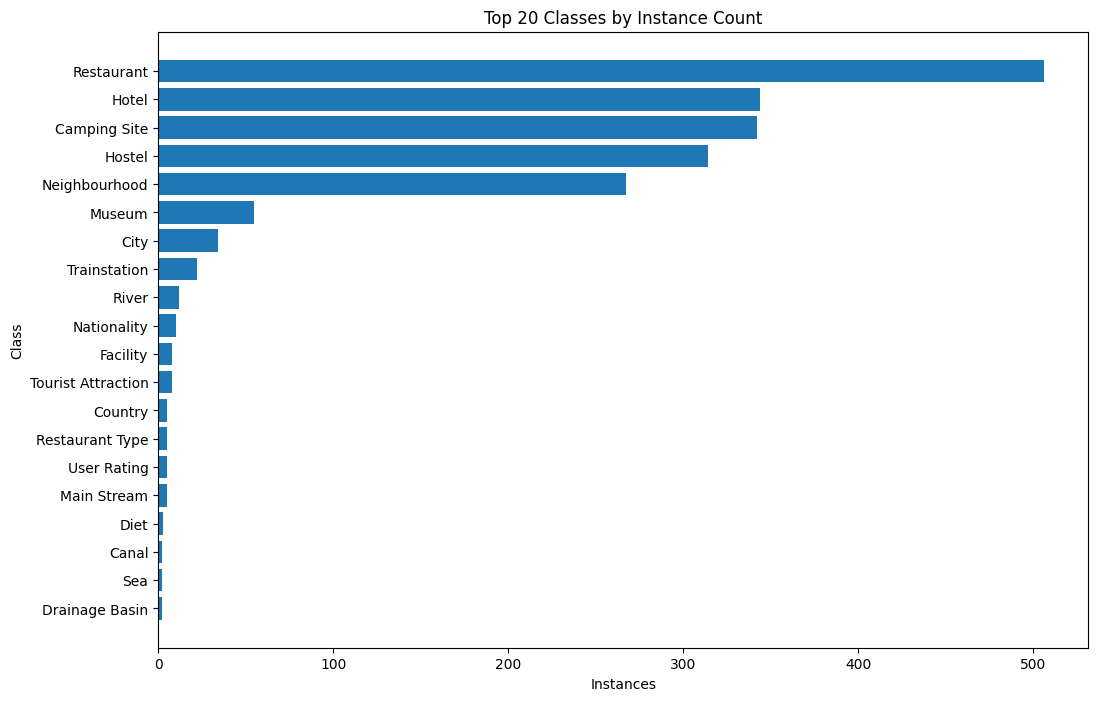

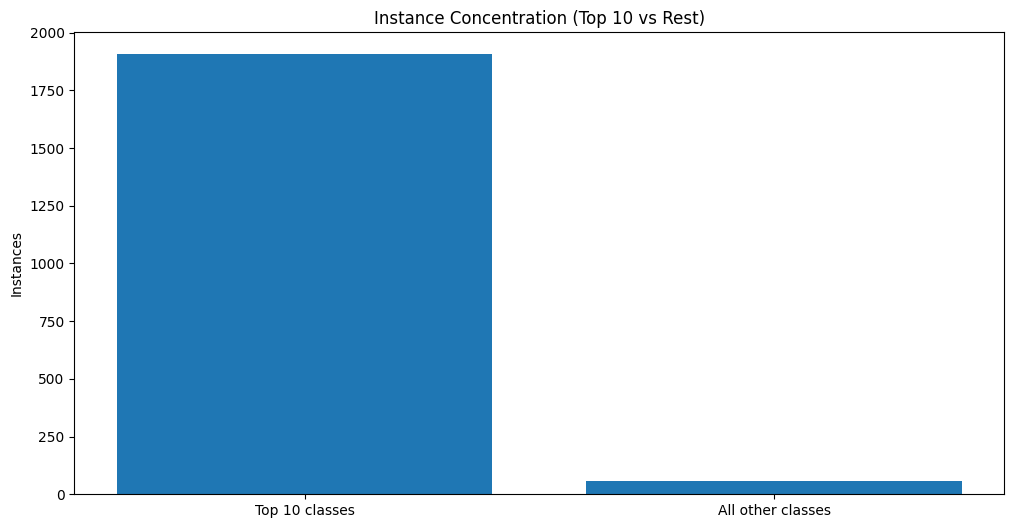


Class hierarchy structure

Top 15 classes by number of subclasses (descendants):
                 Class  NumSubclasses
             WaterBody             12
 AccommodationEntities              5
                 Hotel              2
TransportationEntities              2
          Luxury Hotel              1
              Facility              0
           Nationality              0
       Restaurant Type              0
            Restaurant              0
                  City              0
               Airport              0
          Camping Site              0
                  Diet              0
                Hostel              0
              Landmark              0


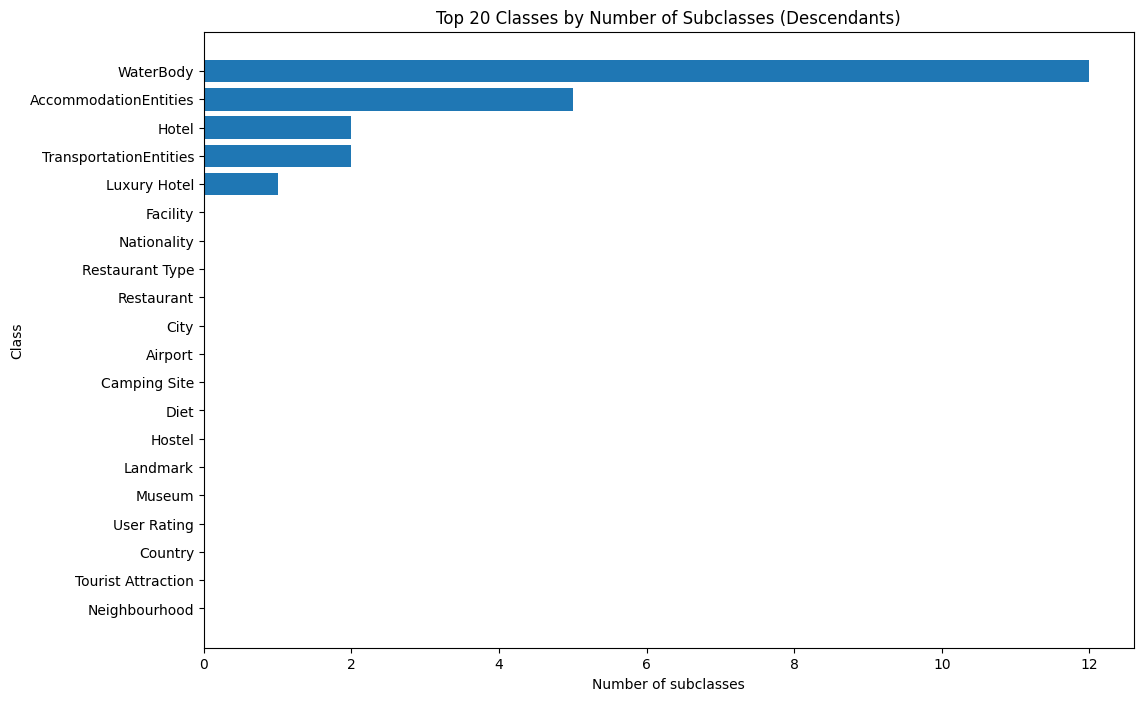

,Class,Count
0,Restaurant,506
1,Hotel,344
2,Camping Site,342
3,Hostel,314
4,Neighbourhood,267
5,Museum,55
6,City,34
7,Trainstation,22
8,River,12
9,Nationality,10


,Class,NumSubclasses
0,WaterBody,12
1,AccommodationEntities,5
2,Hotel,2
3,TransportationEntities,2
4,Luxury Hotel,1
5,Facility,0
6,Nationality,0
7,Restaurant Type,0
8,Restaurant,0
9,City,0



Analysis complete!


In [7]:
plt.rcParams["figure.figsize"] = (12, 6)

reasoner = StructuralReasoner(onto) # Not an actual reasoner, from docs: Tries to check instances fast (but maybe incomplete).

# Pull signatures once
classes = list(onto.classes_in_signature())
object_props = list(onto.object_properties_in_signature())
data_props = list(onto.data_properties_in_signature())
individuals = list(onto.individuals_in_signature())

'''Quick ontology summary'''

print("=" * 70)
print("\nOntology summary\n")
print("=" * 70)

print(f"Classes:           {len(classes)}")
print(f"Object properties: {len(object_props)}")
print(f"Data properties:   {len(data_props)}")
print(f"Individuals:       {len(individuals)}")

plt.figure()
plt.bar(
    ["Classes", "ObjProps", "DataProps", "Individuals"],
    [len(classes), len(object_props), len(data_props), len(individuals)]
)
plt.title("Ontology Component Counts")
plt.ylabel("Count")
plt.show()

'''Individual type distribution'''

print("\n" + "=" * 70)
print("\nIndividual type distribution (direct/asserted)\n")
print("=" * 70)

type_counter = Counter()

for ind in individuals:
    ind_types = reasoner.types(ind, direct=True)
    for cls in ind_types:
        type_counter[get_label(cls, onto)] += 1

type_df = (
    pd.DataFrame(type_counter.items(), columns=["Class", "Count"])
    .sort_values("Count", ascending=False)
    .reset_index(drop=True)
)

print(f"Unique classes with >=1 typed instance: {len(type_df)}")
if len(type_df) > 0:
    print("\nTop 15 classes by instance count:")
    print(type_df.head(15).to_string(index=False))

    # Plot top typed classes
    top_n = min(20, len(type_df))
    top = type_df.head(top_n).iloc[::-1]
    plt.figure(figsize=(12, 8))
    plt.barh(top["Class"], top["Count"])
    plt.title(f"Top {top_n} Classes by Instance Count")
    plt.xlabel("Instances")
    plt.ylabel("Class")
    plt.show()

    top10 = int(type_df.head(min(10, len(type_df)))["Count"].sum())
    rest = int(type_df.iloc[10:]["Count"].sum()) if len(type_df) > 10 else 0

    plt.figure()
    plt.bar(["Top 10 classes", "All other classes"], [top10, rest])
    plt.title("Instance Concentration (Top 10 vs Rest)")
    plt.ylabel("Instances")
    plt.show()
else:
    print("\nNo asserted rdf:type/class assertions found.")

'''Class hierarchy structure'''

print("\n" + "=" * 70)
print("Class hierarchy structure")
print("=" * 70)

sub_counts = []
for c in classes:
    subs = reasoner.sub_classes(c, direct=False)
    subs = set(subs)
    if c in subs:
        subs.remove(c)
    sub_counts.append((get_label(c, onto), len(subs)))

sub_df = (
    pd.DataFrame(sub_counts, columns=["Class", "NumSubclasses"])
    .sort_values("NumSubclasses", ascending=False)
    .reset_index(drop=True)
)

print("\nTop 15 classes by number of subclasses (descendants):")
print(sub_df.head(15).to_string(index=False))

top_n = min(20, len(sub_df))
top = sub_df.head(top_n).iloc[::-1]
plt.figure(figsize=(12, 8))
plt.barh(top["Class"], top["NumSubclasses"])
plt.title(f"Top {top_n} Classes by Number of Subclasses (Descendants)")
plt.xlabel("Number of subclasses")
plt.ylabel("Class")
plt.show()

'''show full panda tables '''

if len(type_df) > 0:
    display(type_df.head(50))

display(sub_df.head(50))

print("\nAnalysis complete!")

# 2. Create a small ontology that can support expressive inference about hotels and analyse the dialogues (examples.txt).

# Create your own dialogues

Once you have created your ontology, use it as the foundation for designing dialogues. Study the examples in examples.txt to understand their structure and content. Then, create 10 dialogues of your own, ensuring a range of difficulty levels: 5 simple ones and 5 more challenging ones. These dialogues should illustrate how your ontology can support reasoning and should include references to the types of information modeled in your ontology.

In [8]:
# Create 10 dialoges based on the description
dialogue1: dict = {"dialogue": "List all hostels that offer free wifi", 
                  "expected_query": "Hostel and has facility value Free_Wifi"}
dialogue2: dict = {"dialogue": "List all hotels near a water body", 
                  "expected_query": "Hotel and near WaterBody"}
dialogue3: dict = {"dialogue": "Find a restaurant that has traditional food", 
                  "expected_query": "Restaurant and (restaurantType value Traditional)"}
dialogue4: dict = {"dialogue": "I want to live in a luxury hotel that has parking along with a swimming pool and sauna", 
                  "expected_query": "LuxuryHotel and (has facility value Parking Space) and (has facility value Swimming Pool) and (has facility value Sauna)"}
dialogue5: dict = {"dialogue": "Show me 4 star camping sites which have Free Wifi", 
                  "expected_query": "CampingSite and (has rating value 4_stars) and (has facility value FreeWifi)"}
dialogue6: dict = {"dialogue": "Give me any hotel in Rome", 
                  "expected_query": "Hotel and 'location' some (Neighbourhood and 'in city' value 'Rome')"}
dialogue7: dict = {"dialogue": "Give me all Accommodation options that are next to Sado River", 
                  "expected_query": "AccommodationEntities and location some (Neighbourhood and 'next to' value 'Sado River')"}
dialogue8: dict = {"dialogue": "Give me any Accommodation next to water body or that has swimming pool", 
                  "expected_query": "AccommodationEntities and 'next to' some WaterBody or 'has facility' value 'Swimming Pool'"}
dialogue9: dict = {"dialogue": "Any accommodation in Lisbon that is in location that has Train Station", 
                  "expected_query": "AccommodationEntities and location some (Neighbourhood and inverse 'location' some Trainstation and 'in city' value 'Lisbon')"}
dialogue10: dict = {"dialogue": "Accommodation that is next to Nantes and has at least 4 facilities", 
                  "expected_query": "AccommodationEntities and location some (Neighbourhood and 'next to' value Nantes)  and 'has facility' min 4 owl:Thing"}
dialogues: list = [dialogue1, dialogue2, dialogue3, dialogue4, dialogue5, dialogue6, dialogue7, dialogue8, dialogue9, dialogue10]

# 3. Deploy a reasoning environment

In [9]:
ontology_path: str = Path("/kaggle/input/rdfontology/data.rdf")

In [10]:
# TODO: load your ontology and create reasoner

from owlapy.owl_ontology import SyncOntology

ontology_path: str = "/kaggle/input/rdfontology/data.rdf"

load = SyncOntology(ontology_path)

reasoner = SyncReasoner(load)

print("Ontology loaded and reasoner ready")


Ontology loaded and reasoner ready


### Test querying code

- Testing if simple query works with our Reasoner setup
- Helper code for findng entity IRI based on rdfs: label (e.g. Rome)

In [11]:
from rdflib import Graph

g = Graph()
g.parse("/kaggle/input/rdfontology/data.rdf")

def iris_by_label(label: str):
    q = f"""
    PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
    SELECT DISTINCT ?s WHERE {{
      ?s rdfs:label "{label}" .
    }}
    """
    return [str(row.s) for row in g.query(q)]

print(iris_by_label("Rome"))

['http://www.wikidata.org/entity/Q220']


In [12]:
namespace = 'http://kai.cs.vu.nl/2024/situated-minor-project/hotel#'

expr_str = (
    "Hotel and "
    "(location some (Neighbourhood and "
    "(inCity value <http://www.wikidata.org/entity/Q220>)))"
)
results = reasoner.instances(manchester_to_owl_expression(expr_str, namespace))

print(results)

{OWLNamedIndividual(IRI('http://kai.cs.vu.nl/2024/situated-minor-project/hotel#', 'accomodation284'))}


# 4. Instruct the LLM to produce the query or components of the query (e.g., keywords) against the KG

In [13]:
!sudo apt-get update && sudo apt-get install -y zstd

!curl -fsSL https://ollama.com/install.sh | sh

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:2 https://cli.github.com/packages stable InRelease [3,917 B]
Get:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:4 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]      
Get:5 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]           
Get:6 https://cli.github.com/packages stable/main amd64 Packages [354 B]       
Hit:7 http://archive.ubuntu.com/ubuntu jammy InRelease                         
Get:8 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [2,297 kB]
Get:9 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]        
Get:10 https://r2u.stat.illinois.edu/ubuntu jammy/main all Packages [9,611 kB] 
Get:11 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [1,289 kB]
Get:12 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelea

In [14]:
#Download ollama
# For Kaggle or Linux: download with this command, for Windows & Mac locally, download executable from website
!curl -fsSL https://ollama.com/install.sh | sh

import subprocess
process = subprocess.Popen("ollama serve", shell=True) #runs on a different thread

#Download Python library
!pip install ollama

>>> Cleaning up old version at /usr/local/lib/ollama
>>> Installing ollama to /usr/local
>>> Downloading ollama-linux-amd64.tar.zst
#######################################################################   99.9%#######################                              61.9%######################                             63.7%################################                      72.9%##############################################           87.7%######################################### 100.0%
>>> Adding ollama user to video group...
>>> Adding current user to ollama group...
>>> Creating ollama systemd service...
>>> The Ollama API is now available at 127.0.0.1:11434.
>>> Install complete. Run "ollama" from the command line.
Couldn't find '/root/.ollama/id_ed25519'. Generating new private key.
Your new public key is: 

ssh-ed25519 AAAAC3NzaC1lZDI1NTE5AAAAINrMbw2s22h7bNZ//nrg0oVkL5A1nFz0ws1oyy2TWMME



time=2026-01-15T22:38:30.395Z level=INFO source=routes.go:1614 msg="server config" env="map[CUDA_VISIBLE_DEVICES: GGML_VK_VISIBLE_DEVICES: GPU_DEVICE_ORDINAL: HIP_VISIBLE_DEVICES: HSA_OVERRIDE_GFX_VERSION: HTTPS_PROXY: HTTP_PROXY: NO_PROXY: OLLAMA_CONTEXT_LENGTH:4096 OLLAMA_DEBUG:INFO OLLAMA_FLASH_ATTENTION:false OLLAMA_GPU_OVERHEAD:0 OLLAMA_HOST:http://127.0.0.1:11434 OLLAMA_KEEP_ALIVE:5m0s OLLAMA_KV_CACHE_TYPE: OLLAMA_LLM_LIBRARY: OLLAMA_LOAD_TIMEOUT:5m0s OLLAMA_MAX_LOADED_MODELS:0 OLLAMA_MAX_QUEUE:512 OLLAMA_MODELS:/root/.ollama/models OLLAMA_MULTIUSER_CACHE:false OLLAMA_NEW_ENGINE:false OLLAMA_NOHISTORY:false OLLAMA_NOPRUNE:false OLLAMA_NUM_PARALLEL:1 OLLAMA_ORIGINS:[http://localhost https://localhost http://localhost:* https://localhost:* http://127.0.0.1 https://127.0.0.1 http://127.0.0.1:* https://127.0.0.1:* http://0.0.0.0 https://0.0.0.0 http://0.0.0.0:* https://0.0.0.0:* app://* file://* tauri://* vscode-webview://* vscode-file://*] OLLAMA_REMOTES:[ollama.com] OLLAMA_SCHED_SP

In [15]:
# Import ollama & pull LLM
import ollama
!ollama pull llama3.2
model: str = "llama3.2"

[GIN] 2026/01/15 - 22:38:40 | 200 |      72.074µs |       127.0.0.1 | HEAD     "/"
pulling manifest ⠋ pulling manifest ⠙ pulling manifest ⠹ pulling manifest ⠸ pulling manifest ⠼ pulling manifest ⠴ pulling manifest ⠦ pulling manifest ⠧ pulling manifest ⠇ pulling manifest ⠏ 

time=2026-01-15T22:38:41.490Z level=INFO source=download.go:177 msg="downloading dde5aa3fc5ff in 16 126 MB part(s)"


pulling manifest ⠋ pulling manifest 
pulling dde5aa3fc5ff:   1% ▕                  ▏  13 MB/2.0 GB                  pulling manifest 
pulling dde5aa3fc5ff:   5% ▕                  ▏  93 MB/2.0 GB                  pulling manifest 
pulling dde5aa3fc5ff:   6% ▕█                 ▏ 127 MB/2.0 GB                  pulling manifest 
pulling dde5aa3fc5ff:  10% ▕█                 ▏ 201 MB/2.0 GB                  pulling manifest 
pulling dde5aa3fc5ff:  14% ▕██                ▏ 279 MB/2.0 GB                  pulling manifest 
pulling dde5aa3fc5ff:  16% ▕██                ▏ 324 MB/2.0 GB                  pulling manifest 
pulling dde5aa3fc5ff:  20% ▕███               ▏ 413 MB/2.0 GB                  pulling manifest 
pulling dde5aa3fc5ff:  25% ▕████              ▏ 496 MB/2.0 GB                  pulling manifest 
pulling dde5aa3fc5ff:  27% ▕████              ▏ 543 MB/2.0 GB                  pulling manifest 
pulling dde5aa3fc5ff:  31% ▕█████             ▏ 626 MB/2.0 GB                  pulling man

time=2026-01-15T22:38:47.785Z level=INFO source=download.go:177 msg="downloading 966de95ca8a6 in 1 1.4 KB part(s)"


pulling manifest 
pulling dde5aa3fc5ff: 100% ▕██████████████████▏ 2.0 GB                         pulling manifest 
pulling dde5aa3fc5ff: 100% ▕██████████████████▏ 2.0 GB                         
pulling 966de95ca8a6: 100% ▕██████████████████▏ 1.4 KB                         pulling manifest 
pulling dde5aa3fc5ff: 100% ▕██████████████████▏ 2.0 GB                         
pulling 966de95ca8a6: 100% ▕██████████████████▏ 1.4 KB                         pulling manifest 
pulling dde5aa3fc5ff: 100% ▕██████████████████▏ 2.0 GB                         
pulling 966de95ca8a6: 100% ▕██████████████████▏ 1.4 KB                         pulling manifest 
pulling dde5aa3fc5ff: 100% ▕██████████████████▏ 2.0 GB                         
pulling 966de95ca8a6: 100% ▕██████████████████▏ 1.4 KB                         pulling manifest 
pulling dde5aa3fc5ff: 100% ▕██████████████████▏ 2.0 GB                         
pulling 966de95ca8a6: 100% ▕██████████████████▏ 1.4 KB                         pulling manifest 


time=2026-01-15T22:38:49.057Z level=INFO source=download.go:177 msg="downloading fcc5a6bec9da in 1 7.7 KB part(s)"


pulling manifest 
pulling dde5aa3fc5ff: 100% ▕██████████████████▏ 2.0 GB                         
pulling 966de95ca8a6: 100% ▕██████████████████▏ 1.4 KB                         
pulling fcc5a6bec9da: 100% ▕██████████████████▏ 7.7 KB                         pulling manifest 
pulling dde5aa3fc5ff: 100% ▕██████████████████▏ 2.0 GB                         
pulling 966de95ca8a6: 100% ▕██████████████████▏ 1.4 KB                         
pulling fcc5a6bec9da: 100% ▕██████████████████▏ 7.7 KB                         pulling manifest 
pulling dde5aa3fc5ff: 100% ▕██████████████████▏ 2.0 GB                         
pulling 966de95ca8a6: 100% ▕██████████████████▏ 1.4 KB                         
pulling fcc5a6bec9da: 100% ▕██████████████████▏ 7.7 KB                         pulling manifest 
pulling dde5aa3fc5ff: 100% ▕██████████████████▏ 2.0 GB                         
pulling 966de95ca8a6: 100% ▕██████████████████▏ 1.4 KB                         
pulling fcc5a6bec9da: 100% ▕██████████████████▏ 7.7

time=2026-01-15T22:38:50.330Z level=INFO source=download.go:177 msg="downloading a70ff7e570d9 in 1 6.0 KB part(s)"


pulling manifest 
pulling dde5aa3fc5ff: 100% ▕██████████████████▏ 2.0 GB                         
pulling 966de95ca8a6: 100% ▕██████████████████▏ 1.4 KB                         
pulling fcc5a6bec9da: 100% ▕██████████████████▏ 7.7 KB                         pulling manifest 
pulling dde5aa3fc5ff: 100% ▕██████████████████▏ 2.0 GB                         
pulling 966de95ca8a6: 100% ▕██████████████████▏ 1.4 KB                         
pulling fcc5a6bec9da: 100% ▕██████████████████▏ 7.7 KB                         
pulling a70ff7e570d9: 100% ▕██████████████████▏ 6.0 KB                         pulling manifest 
pulling dde5aa3fc5ff: 100% ▕██████████████████▏ 2.0 GB                         
pulling 966de95ca8a6: 100% ▕██████████████████▏ 1.4 KB                         
pulling fcc5a6bec9da: 100% ▕██████████████████▏ 7.7 KB                         
pulling a70ff7e570d9: 100% ▕██████████████████▏ 6.0 KB                         pulling manifest 
pulling dde5aa3fc5ff: 100% ▕██████████████████▏ 2.0

time=2026-01-15T22:39:00.451Z level=INFO source=download.go:177 msg="downloading 56bb8bd477a5 in 1 96 B part(s)"


pulling manifest 
pulling dde5aa3fc5ff: 100% ▕██████████████████▏ 2.0 GB                         
pulling 966de95ca8a6: 100% ▕██████████████████▏ 1.4 KB                         
pulling fcc5a6bec9da: 100% ▕██████████████████▏ 7.7 KB                         
pulling a70ff7e570d9: 100% ▕██████████████████▏ 6.0 KB                         pulling manifest 
pulling dde5aa3fc5ff: 100% ▕██████████████████▏ 2.0 GB                         
pulling 966de95ca8a6: 100% ▕██████████████████▏ 1.4 KB                         
pulling fcc5a6bec9da: 100% ▕██████████████████▏ 7.7 KB                         
pulling a70ff7e570d9: 100% ▕██████████████████▏ 6.0 KB                         
pulling 56bb8bd477a5: 100% ▕██████████████████▏   96 B                         pulling manifest 
pulling dde5aa3fc5ff: 100% ▕██████████████████▏ 2.0 GB                         
pulling 966de95ca8a6: 100% ▕██████████████████▏ 1.4 KB                         
pulling fcc5a6bec9da: 100% ▕██████████████████▏ 7.7 KB              

time=2026-01-15T22:39:01.732Z level=INFO source=download.go:177 msg="downloading 34bb5ab01051 in 1 561 B part(s)"


pulling manifest 
pulling dde5aa3fc5ff: 100% ▕██████████████████▏ 2.0 GB                         
pulling 966de95ca8a6: 100% ▕██████████████████▏ 1.4 KB                         
pulling fcc5a6bec9da: 100% ▕██████████████████▏ 7.7 KB                         
pulling a70ff7e570d9: 100% ▕██████████████████▏ 6.0 KB                         
pulling 56bb8bd477a5: 100% ▕██████████████████▏   96 B                         pulling manifest 
pulling dde5aa3fc5ff: 100% ▕██████████████████▏ 2.0 GB                         
pulling 966de95ca8a6: 100% ▕██████████████████▏ 1.4 KB                         
pulling fcc5a6bec9da: 100% ▕██████████████████▏ 7.7 KB                         
pulling a70ff7e570d9: 100% ▕██████████████████▏ 6.0 KB                         
pulling 56bb8bd477a5: 100% ▕██████████████████▏   96 B                         
pulling 34bb5ab01051: 100% ▕██████████████████▏  561 B                         pulling manifest 
pulling dde5aa3fc5ff: 100% ▕██████████████████▏ 2.0 GB              

In [16]:
#Step 1: Write the instruction for the LLM - remember the overarching topic (assistance with hotels), as well as the fact that
# this step is meant to merely extract queries from the user input.

# Instruct LLM
instruction: str = """You are an AI assistant which is going to be used by users to query a Hospitality knowledge databased 
The goal for you is to translate the user's natural language statement/question into a description logic query using Manchester Syntax

Rules -
Output only Manchester Syntax query string without any unnecessary symbols (like \n etc). Don't include explanations or controversial text.
Exact words matter along with the casing such as "Hotel" and not "hotel"
For values such as city names use the 'value' keyword  with the city name inside double quotes.
Combine multiple conditions using 'and' 'or' and 'not'

Use only the classes and properties from the dataset in your query. this is our ontology schema:

Object properties:

diet

hasFacility

inCity

inCountry

location

nationality

nextTo

restaurantType

userRating

topObjectProperty

Classes

Airport

Camping_Site

City

Country

Diet

Facility

Hostel

Hotel

Landmark

Museum

Nationality

Neighbourhood

Restaurant

RestaurantType

TouristAttraction

Trainstation

UserRating

AccommodationEntities

LuxuryHotel

TransportationEntities

WaterBody

Individuals

1_stars

2_stars

3_stars

4_stars

5_stars

24h_front_desk

Swimming_Pool

Sauna

Airport_Shuttle

Private_Bathroom

Parking_Space

RestaurantInHotel

Free_Wifi

Examples - 
User: "I am looking for a hotel in Amsterdam"
Query: Hotel and inCity value "Amsterdam"

User: "Show me camping sites in Paris"
Query: CampingSite and inCity value "Paris"

User: "Show me camping site with airpot shuttle"
Query: CampingSite and hasFacility value Airport_Shuttle

User: "Find hotels with a rating of 5 stars"
Query: Hotel and has rating value "5-stars"
"""

In [17]:
#Step 2: Write a function that takes the model, instruction and one user question as input, runs the LLM and outputs its response
def question_to_query(instruction: str, question: str, model="llama3.2") -> str:
    '''
    This function is meant to use the instruction defined above to run the LLM in order to convert one user input
    question into a query for the ontology reasoner.
    Parameters: instruction (string), question (string), model version (string)
    Returns: LLM response (string)
    '''

    messages = [
        {'role': 'system', 'content': instruction},
        {'role': 'user', 'content': question}
    ]

    response = ollama.chat(
        model=model,
        messages=messages
    )

    output = response['message']['content']

    return output.strip()

In [18]:
#Step 3: Run the LLM for each example defined above

# Helper function
def find_between(s: str, start: str, end: str) -> str:
    return s.split(start)[1].split(end)[0]

queries = []

for item in dialogues:
   
    user_question = item['dialogue'] # This change has been made since we are using dictionaries and not strings in our dialogues
    print("User question:", user_question)
    print()
    result: str = question_to_query(instruction, user_question, model)
    # Possibly only extract the relevant parts
    print("Extracted query:", result)
    queries.append(result)
    print()

User question: List all hostels that offer free wifi



time=2026-01-15T22:40:54.436Z level=INFO source=server.go:429 msg="starting runner" cmd="/usr/local/bin/ollama runner --ollama-engine --port 34655"
llama_model_loader: loaded meta data with 30 key-value pairs and 255 tensors from /root/.ollama/models/blobs/sha256-dde5aa3fc5ffc17176b5e8bdc82f587b24b2678c6c66101bf7da77af9f7ccdff (version GGUF V3 (latest))
llama_model_loader: Dumping metadata keys/values. Note: KV overrides do not apply in this output.
llama_model_loader: - kv   0:                       general.architecture str              = llama
llama_model_loader: - kv   1:                               general.type str              = model
llama_model_loader: - kv   2:                               general.name str              = Llama 3.2 3B Instruct
llama_model_loader: - kv   3:                           general.finetune str              = Instruct
llama_model_loader: - kv   4:                           general.basename str              = Llama-3.2
llama_model_loader: - kv   5:    

[GIN] 2026/01/15 - 22:40:57 | 200 |  2.907550116s |       127.0.0.1 | POST     "/api/chat"
Extracted query: Hostel and hasFacility Free_Wifi

User question: List all hotels near a water body

[GIN] 2026/01/15 - 22:40:58 | 200 |  1.537073789s |       127.0.0.1 | POST     "/api/chat"
Extracted query: Hospitality Ontology Query:

for object variable H . 
    exists( hasFacility H ) .
    for object variable W . 
        isA WaterBody .
        exists ( inLocation W ) .
        exists( nextTo W ) .
        for object variable Hotel .
            isA Hotel .
            exists ( nextTo Hotel ) .
            sameAs( nextTo Hotel , W ) .
        )
return H

User question: Find a restaurant that has traditional food

[GIN] 2026/01/15 - 22:40:59 | 200 |  433.612148ms |       127.0.0.1 | POST     "/api/chat"
Extracted query: RestaurantType and hasFacility value Traditional_Food

User question: I want to live in a luxury hotel that has parking along with a swimming pool and sauna

[GIN] 2026/01/1

In [21]:
queries[0]

'Hostel and hasFacility Free_Wifi'

# 5. Use an LLM to summarize some result into a natural language response to the user.

In [22]:
def reason(query: str) -> list[str]:
    """
    Convert a query into an OWL expression and return inferred instance IRIs.
    If the reasoner fails, return ["No data found"].
    """
    namespace = 'http://kai.cs.vu.nl/2024/situated-minor-project/hotel#'

    try:
        results = reasoner.instances(
            manchester_to_owl_expression(query, namespace)
        )
    except Exception:
        return ["No data found"]

    iris: list[str] = []

    for ind in results:
        if hasattr(ind, "iri"):
            iris.append(str(ind.iri))
        else:
            iris.append(str(ind))

    return iris if iris else ["No data found"]

In [23]:
#Step 2: Instruct & run the LLM for the new task: transform the extracted knowledge into a natural language response based
# on the original question
def knowledge_to_response(question: str, knowledge: str, model="llama3.2"):
    '''
    This function is meant to write an instruction based on an item of extracted knowledge and the original user
    question, and run the LLM to summarize a response.
    '''
    print("="*70)
    print("Question:", question,"\n")
    messages = [
        {'role': 'system', 'content': "This is related knowledge"+knowledge},
        {'role': 'user', 'content': question}
    ]

    response = ollama.chat(
        model=model,
        messages=messages
    )

    output = response['message']['content']

    return output.strip()

In [24]:
print(queries[0])
reason(queries[0])

Hostel and hasFacility Free_Wifi


['No data found']

In [25]:
#Step 3: Combine everything: generate queries from the dialogues, extract knowledge from queries with the reasoner and
for i in range(len(dialogues)):
    print("reasoning")
    reasoner_result_str = "\n".join(reason(queries[i])) or "No results."
    print("finished reasoning")
    knowledge_result = knowledge_to_response(dialogues[i]['dialogue'], reasoner_result_str)
    print(knowledge_result)
    print("="*70)

reasoning
finished reasoning
Question: List all hostels that offer free wifi 

[GIN] 2026/01/15 - 22:43:58 | 200 |  6.787289655s |       127.0.0.1 | POST     "/api/chat"
However, I'm a large language model, I don't have real-time access to specific hostel information. Hostel offerings and policies can change frequently.

That being said, here are some popular hostel chains that often offer free WiFi:

1. **Hostelworld**: Many hostels on their platform offer free WiFi. You can filter search results by "Free WiFi" or "WiFi Included".
2. **Hostelling International (HI)**: HI is a global network of youth hostels that offers free WiFi in many of its locations.
3. **Meininger Hostels**: Meininger has over 30 locations across Europe and Asia, offering free WiFi to all guests.
4. **Generator Hostels**: Generator has hostels in London, Paris, Berlin, Amsterdam, and other European cities, with free WiFi available in most locations.
5. **St Christopher's Inn**: St Christopher's has hostels in var

time=2026-01-15T22:50:22.009Z level=INFO source=server.go:429 msg="starting runner" cmd="/usr/local/bin/ollama runner --ollama-engine --port 36835"
time=2026-01-15T22:50:22.450Z level=INFO source=server.go:429 msg="starting runner" cmd="/usr/local/bin/ollama runner --ollama-engine --port 33791"


# 6. Evaluate your LLM

In [31]:
# TODO: your code to implement and demonstrate evaluation metrics
# Suggestions: comparison of generated queries with the queries manually created in examples.txt, Intersection Over Union,
# but you can be creative here

import pandas as pd
import matplotlib.pyplot as plt

def calculate_similarity(text1, text2):
    """
    Calculates the similarity of tokens between two strings.
    Comparing generated query with the expected query.
    """
    # Tokenizing the strings
    tokens1 = set(str(text1).lower().replace('(', '').replace(')', '').split())
    tokens2 = set(str(text2).lower().replace('(', '').replace(')', '').split())
    
    if len(tokens1) == 0 or len(tokens2) == 0:
        return 0.0
    
    intersection = tokens1.intersection(tokens2)
    union = tokens1.union(tokens2)
    
    return len(intersection) / len(union)

print ("Automatic Query Evaluation")

generated_results = []

#iterating through the expected queries
for i, item in enumerate(dialogues):
    if i >= len(queries):
        break
    
    user_input = item['dialogue']
    expected_query = item['expected_query']
    generated_query = queries[i]

    similarity_score = calculate_similarity(generated_query,expected_query)

    generated_results.append({
        "ID": i + 1,
        "User Input": user_input,
        "Expected Query": expected_query,
        "Generated Query": generated_query,
        "Similarity Score": similarity_score
    })

df_automated = pd.DataFrame(generated_results)

display(df_automated)

print(f"Average Similarity Score: {df_automated['Similarity Score'].mean():.4f}")

print(" ------------------------------------------------- ")
print('Manual Query Evaluation:')

for i, (item, gen_query) in enumerate(zip(dialogues, queries)):
    print(f"\n--- Dialogue {i+1} ---")
    print(f"User Input: {item['dialogue']}")
    print(f"EXPECTED:   {item['expected_query']}")
    print(f"GENERATED:  {gen_query}")


Automatic Query Evaluation


,ID,User Input,Expected Query,Generated Query,Similarity Score
0,1,List all hostels that offer free wifi,Hostel and has facility value Free_Wifi,Hostel and hasFacility Free_Wifi,0.428571
1,2,List all hotels near a water body,Hotel and near WaterBody,Hospitality Ontology Query:\n\nfor object vari...,0.095238
2,3,Find a restaurant that has traditional food,Restaurant and (restaurantType value Traditional),RestaurantType and hasFacility value Tradition...,0.428571
3,4,I want to live in a luxury hotel that has park...,LuxuryHotel and (has facility value Parking Sp...,LuxuryHotel and hasFacility value Parking_Spac...,0.307692
4,5,Show me 4 star camping sites which have Free Wifi,CampingSite and (has rating value 4_stars) and...,"Camping_Site and inCity value ""value"" and hasF...",0.142857
5,6,Give me any hotel in Rome,Hotel and 'location' some (Neighbourhood and '...,"Hotel and inCity value ""Rome""",0.272727
6,7,Give me all Accommodation options that are nex...,AccommodationEntities and location some (Neigh...,"AccommodationEntities and WaterBody, with the ...",0.157895
7,8,Give me any Accommodation next to water body o...,AccommodationEntities and 'next to' some Water...,AccommodationEntity and (nextTo WaterBody or h...,0.187500
8,9,Any accommodation in Lisbon that is in locatio...,AccommodationEntities and location some (Neigh...,"Hotel and inLocation value ""Train station in L...",0.111111
9,10,Accommodation that is next to Nantes and has a...,AccommodationEntities and location some (Neigh...,"Hotel or Hostel and inCity value ""Nantes"" and ...",0.083333


Average Similarity Score: 0.2215
 ------------------------------------------------- 
Manual Query Evaluation

--- Dialogue 1 ---
User Input: List all hostels that offer free wifi
EXPECTED:   Hostel and has facility value Free_Wifi
GENERATED:  Hostel and hasFacility Free_Wifi

--- Dialogue 2 ---
User Input: List all hotels near a water body
EXPECTED:   Hotel and near WaterBody
GENERATED:  Hospitality Ontology Query:

for object variable H . 
    exists( hasFacility H ) .
    for object variable W . 
        isA WaterBody .
        exists ( inLocation W ) .
        exists( nextTo W ) .
        for object variable Hotel .
            isA Hotel .
            exists ( nextTo Hotel ) .
            sameAs( nextTo Hotel , W ) .
        )
return H

--- Dialogue 3 ---
User Input: Find a restaurant that has traditional food
EXPECTED:   Restaurant and (restaurantType value Traditional)
GENERATED:  RestaurantType and hasFacility value Traditional_Food

--- Dialogue 4 ---
User Input: I want to live 